# Midd Xpress Grocery Checkout
Sirui Chen and Haonan Dong

## Introduction
### Goal:
The primary objective of this project is to develop a robust system for identifying grocery items based on images. The system combines multiple techniques—dominant color extraction, text extraction using Optical Character Recognition (OCR), and feature extraction using ORB (Oriented FAST and Rotated BRIEF) descriptors—to achieve high accuracy in object identification. This multi-faceted approach ensures that the system can effectively recognize items even under varying conditions and perspectives.
### Context:
This project is situated within the realm of computer vision and machine learning, specifically focusing on image processing and pattern recognition. It aligns with the goals of our computer science course, which emphasizes the application of algorithms and data structures to solve real-world problems. The project leverages state-of-the-art libraries and techniques that we have studied throughout the course, including OpenCV for image processing, scikit-learn for clustering, and Tesseract for text recognition.
### Motivation:
The motivation behind this project stems from the increasing demand for automated systems that can assist in inventory management, self-checkout systems in retail, and other applications where quick and accurate item identification is crucial. By integrating multiple identification techniques, the system aims to overcome the limitations of using a single method, thus providing a more reliable solution.
### Sources Consulted:
1. OpenCV documentation
2. Tesseract OCR documentation
3. Scikit-learn documentation
4. Various research papers and online resources related to image processing and feature extraction


## Methods
### Algorithm Description:
The core algorithm of this project integrates three primary methods for object identification:

1. **Dominant Color Extraction**:
The system processes each image to isolate the object from its background using color filtering techniques.
K-means clustering is applied to the filtered image to identify the top three dominant colors, which are then used for initial matching against a reference dataset.
2. **Text Extraction**:
The Tesseract OCR engine is employed to extract any textual information present on the object. This text is then compared against known text references for each object type.
3. **Feature Extraction**:
ORB (Oriented FAST and Rotated BRIEF) descriptors are extracted from the images. These features are matched against precomputed descriptors of reference images to find the closest matches.
Feature extraction is given more weight in the final decision process to enhance accuracy, especially for objects with similar colors or text.

### Incorporation of Existing Projects and Libraries:

1. OpenCV: Used extensively for image processing tasks such as color space conversion, masking, and feature detection.
2. Tesseract OCR: Utilized for extracting text from images. This library provides robust text recognition capabilities that are critical for identifying items with distinctive text.
3. Scikit-learn: Applied for clustering pixel values to determine dominant colors. The K-means algorithm from this library is particularly useful for this purpose.

### Code Logic and Design:
The code is designed to be modular, with separate functions handling each stage of the identification process. This modularity ensures that each component can be developed, tested, and optimized independently before being integrated into the final pipeline.

### UI:


### Steps and Functions:

1. Image Preprocessing and Segmentation:
`preprocess_image(image)`: Enhances the image using CLAHE (Contrast Limited Adaptive Histogram Equalization).
`filter_colors(hsv_image)`: Filters out the background colors to isolate the object.

2. Dominant Color Extraction:
`find_dominant_colors(image_path, num_colors=3)`: Extracts the top three dominant colors using K-means clustering.

3. Text Extraction:
`extract_text(image_path)`: Extracts text from the image using Tesseract OCR.

4. Feature Extraction:
`extract_features(image_path)`: Extracts ORB features from the image.

5. Combined Pipeline:
`combined_pipeline(image_path, reference_colors_dict, output_path=None, text_reference=None, feature_reference=None, name_mapping=None, feature_weight=2)`: Integrates all the above methods to identify the object and outputs the top three matches.

# Installation Checklist

In [61]:
# Installation Checklist
# This cell installs all the necessary packages and tools required to run the notebook

import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install necessary packages
install("opencv-python-headless")
install("numpy")
install("matplotlib")
install("scikit-learn")
install("pytesseract")

# Install Tesseract OCR based on the operating system
import platform
import os

def install_tesseract():
    system = platform.system()
    if system == "Windows":
        # Windows: Download and install Tesseract from https://github.com/UB-Mannheim/tesseract/wiki
        print("Please download and install Tesseract OCR from https://github.com/UB-Mannheim/tesseract/wiki and add it to your PATH.")
    elif system == "Darwin":  # macOS
        # macOS: Install Tesseract using Homebrew
        os.system("brew install tesseract")
    elif system == "Linux":
        # Linux: Install Tesseract using apt-get
        os.system("sudo apt-get update && sudo apt-get install -y tesseract-ocr")
    else:
        raise Exception(f"Unsupported operating system: {system}")

install_tesseract()

# Verify installations
try:
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    import pytesseract
    print("All packages installed successfully!")
except ImportError as e:
    print(f"Error: {e}. Please ensure all packages are installed correctly.")


All packages installed successfully!


To reinstall 5.3.4_1, run:
  brew reinstall tesseract


In [62]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pytesseract
import tkinter as tk
from tkinter import filedialog, Label, Button, Canvas, Text, messagebox
from PIL import Image, ImageTk

In [63]:
# Set the path to be the folder you are downloading everything to
path = '/Users/RayChen/csci0452/Final_Project/'

In [64]:
name_mapping = {
    'object_1': 'Coca Cola',
    'object_2': 'Pepsi',
    'object_3': 'Orange Crush',
    'object_4': 'Cup Noodles',
    'object_5': 'Lays Salt & Vinegar',
    'object_6': 'Oreo mini',
    'object_7': 'Cheeze_it',
    'object_8': 'Deep River Chips',
    'object_9': 'Ritz Cracker',
    'object_10': 'Milano Cookie'
}

# Preprocessing and extract objects
This part involves preprocessing the images to enhance their quality and then isolating the objects from the green background. The images are converted to LAB color space, and CLAHE (Contrast Limited Adaptive Histogram Equalization) is applied to improve contrast. The background is filtered out to isolate the objects

In [65]:
import cv2
import numpy as np
import os

def preprocess_image(image):
    '''
    Args:
        image (ndarray): The input image to preprocess.
        
    Output:
        processed_img (ndarray): The preprocessed image.
        
    Usage:
        processed_img = preprocess_image(image)
    '''
    # Convert to LAB color space to apply CLAHE
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    # Convert back to BGR color space
    processed_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return processed_img

def segment_object_from_green(image_path, output_path):
    '''
    Args:
        image_path (str): Path to the input image.
        output_path (str): Path to save the segmented image.
        
    Output:
        None
        
    Usage:
        segment_object_from_green('input.jpg', 'output.png')
    '''
    # Load the image
    image = cv2.imread(image_path)
    # Preprocess the image
    preprocessed_image = preprocess_image(image)
    # Convert to HSV
    hsv_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2HSV)
    # Define the range for the green color
    lower_green = np.array([31, 13, 40])  # Adjust these values based on your specific green
    upper_green = np.array([74, 255, 255])
    # Create a mask to isolate the green background
    mask = cv2.inRange(hsv_image, lower_green, upper_green)
    mask = cv2.bitwise_not(mask)  # Invert the mask to get the object
    # Apply the mask to get the object
    object_extracted = cv2.bitwise_and(preprocessed_image, preprocessed_image, mask=mask)
    # Save the processed image
    cv2.imwrite(output_path, object_extracted)

def process_images(input_dir, output_dir):
    # Verify output directory exists, if not, create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List all image files
    image_files = [f for f in os.listdir(input_dir) if f.startswith('image_') and f.endswith('.jpg')]
    image_files.sort()  # Sort to maintain numerical order

    # Segment and save each image
    for i, filename in enumerate(image_files, start=1):
        image_path = os.path.join(input_dir, filename)
        output_filename = f'obj_{i:02d}.jpg'
        output_path = os.path.join(output_dir, output_filename)
        segment_object_from_green(image_path, output_path)
        print(f'Processed {filename} and saved as {output_filename}')

# Input and output directories
input_directory_path = path + 'Images'
output_directory_path = path + 'Segmented_Images'

# Call the processing function
process_images(input_directory_path, output_directory_path)


Processed image_01.jpg and saved as obj_01.jpg
Processed image_02.jpg and saved as obj_02.jpg
Processed image_03.jpg and saved as obj_03.jpg
Processed image_04.jpg and saved as obj_04.jpg
Processed image_05.jpg and saved as obj_05.jpg
Processed image_06.jpg and saved as obj_06.jpg
Processed image_07.jpg and saved as obj_07.jpg
Processed image_08.jpg and saved as obj_08.jpg
Processed image_09.jpg and saved as obj_09.jpg
Processed image_10.jpg and saved as obj_10.jpg
Processed image_11.jpg and saved as obj_11.jpg
Processed image_12.jpg and saved as obj_12.jpg
Processed image_13.jpg and saved as obj_13.jpg
Processed image_14.jpg and saved as obj_14.jpg
Processed image_15.jpg and saved as obj_15.jpg
Processed image_16.jpg and saved as obj_16.jpg
Processed image_17.jpg and saved as obj_17.jpg
Processed image_18.jpg and saved as obj_18.jpg
Processed image_19.jpg and saved as obj_19.jpg
Processed image_20.jpg and saved as obj_20.jpg
Processed image_21.jpg and saved as obj_21.jpg
Processed ima

# Identify Dominant Color
In this section, the top three dominant colors of the isolated objects are identified using K-means clustering. The identified colors are then used to match against reference colors for preliminary object identification.

In [66]:
def filter_colors(hsv_image):
    mask_black = cv2.inRange(hsv_image, (0, 0, 0), (180, 255, 35))  # More aggressive on dark colors
    mask_green = cv2.inRange(hsv_image, (20, 50, 50), (90, 255, 255))  # Broaden the green range
    mask_white = cv2.inRange(hsv_image, (0, 0, 180), (180, 25, 255))  # Tighten white range to high values

    # Combine masks for black, green, and white
    combined_mask = cv2.bitwise_or(mask_black, mask_green)
    combined_mask = cv2.bitwise_or(combined_mask, mask_white)
    combined_mask = cv2.bitwise_not(combined_mask)  # Invert mask

    filtered_image = cv2.bitwise_and(hsv_image, hsv_image, mask=combined_mask)
    return filtered_image

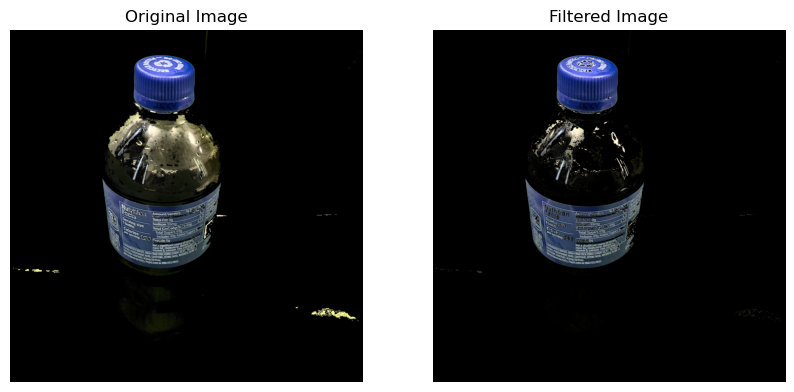

In [67]:
import matplotlib.pyplot as plt

def plot_filtered_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    filtered_image = filter_colors(hsv_image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_HSV2RGB))
    plt.title('Filtered Image')
    plt.axis('off')

    plt.show()

# Example use
plot_filtered_image(path + 'Segmented_Images/obj_06.jpg')


In [68]:
from sklearn.cluster import KMeans
import numpy as np
import cv2

def find_dominant_colors(image_path, num_colors=4, top_n=3):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Unable to load the image at path: {image_path}")
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    filtered_image = filter_colors(hsv_image)
    pixel_values = filtered_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Run K-means
    kmeans = KMeans(n_clusters=num_colors, random_state=0, n_init='auto').fit(pixel_values)
    unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)

    # Filter centroids that are likely to be 'real' and not 'averaged' improperly
    centroids = kmeans.cluster_centers_
    valid_centroids = [centroid for centroid in centroids if not (20 <= centroid[0] <= 90 and centroid[1] > 50)]

    # If all centroids are filtered out, take the largest by count
    if not valid_centroids:
        sorted_indices = np.argsort(counts)[::-1]
        dominant_colors = centroids[sorted_indices][:top_n]
    else:
        # Sort centroids by intensity and saturation, and take the top N
        valid_centroids = sorted(valid_centroids, key=lambda x: np.sqrt(x[1]**2 + x[2]**2), reverse=True)
        dominant_colors = valid_centroids[:top_n]

    dominant_colors = [np.uint8(color) for color in dominant_colors]
    print("Top 3 Dominant colors (HSV):", dominant_colors)
    return dominant_colors

In [69]:
def hsv_distance(color1, color2):
    # Convert colors to int to prevent data type overflow issues
    color1 = np.array(color1, dtype=int)
    color2 = np.array(color2, dtype=int)
    
    # Calculate differences in hue, saturation, and value
    hue_diff = min(abs(color1[0] - color2[0]), 360 - abs(color1[0] - color2[0])) / 180.0
    sat_diff = abs(color1[1] - color2[1]) / 255.0
    val_diff = abs(color1[2] - color2[2]) / 255.0
    
    # Calculate Euclidean distance in HSV space
    distance = np.sqrt(hue_diff**2 + sat_diff**2 + val_diff**2)
    return distance

def compare_dominant_colors(colors1, colors2, threshold=0.1):
    if isinstance(colors1, list):
        colors1 = np.array(colors1)
    if isinstance(colors2, list):
        colors2 = np.array(colors2)

    if colors1.ndim == 1:
        colors1 = colors1[np.newaxis, :]
    if colors2.ndim == 1:
        colors2 = colors2[np.newaxis, :]

    for color1 in colors1:
        for color2 in colors2:
            distance = hsv_distance(color1, color2)
            print(f"Comparing {color1} to {color2}, Distance: {distance}")  # Debugging output
            if distance < threshold:
                return True
    return False


In [70]:
try:
    colors1 = find_dominant_colors(path + 'Segmented_Images/obj_27.jpg')
    colors2 = find_dominant_colors(path + 'Segmented_Images/obj_04.jpg')
    is_similar = compare_dominant_colors(colors1, colors2)
    print("Objects are similar:", is_similar)
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

Top 3 Dominant colors (HSV): [array([178, 232, 154], dtype=uint8), array([  4, 167, 210], dtype=uint8), array([  5, 240, 113], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([173,  74, 237], dtype=uint8), array([  2, 144, 192], dtype=uint8), array([0, 0, 0], dtype=uint8)]
Comparing [178 232 154] to [173  74 237], Distance: 0.7004493928605038
Comparing [178 232 154] to [  2 144 192], Distance: 1.0475442152521692
Comparing [178 232 154] to [0 0 0], Distance: 1.4732160979717115
Comparing [  4 167 210] to [173  74 237], Distance: 1.0127851692072756
Comparing [  4 167 210] to [  2 144 192], Distance: 0.1150716660019289
Comparing [  4 167 210] to [0 0 0], Distance: 1.0524215398029229
Comparing [  5 240 113] to [173  74 237], Distance: 1.2374770628051488
Comparing [  5 240 113] to [  2 144 192], Distance: 0.4878384480576602
Comparing [  5 240 113] to [0 0 0], Distance: 1.040651421182542
Objects are similar: False


In [71]:
def show_hsv_color(ax, hsv_values, title):
    # Convert list to numpy array if necessary
    if isinstance(hsv_values, list):
        hsv_values = np.array(hsv_values)
    
    # Ensure hsv_values is always in the shape of (1, 1, 3)
    if hsv_values.ndim == 1:
        hsv_values = hsv_values[np.newaxis, np.newaxis, :]
    elif hsv_values.ndim == 2 and hsv_values.shape[0] == 1:
        hsv_values = hsv_values[np.newaxis, :]

    color_image = np.uint8(hsv_values)
    color_image = cv2.cvtColor(color_image, cv2.COLOR_HSV2BGR)
    color_image = np.tile(color_image, (100, 100, 1))
    rgb_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb_image)
    ax.axis('off')
    ax.set_title(title)


In [72]:
def compare_and_visualize_colors(image_path1, image_path2):
    try:
        colors1 = find_dominant_colors(image_path1, num_colors=4, top_n=3)
        colors2 = find_dominant_colors(image_path2, num_colors=4, top_n=3)
        
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        
        for i, color in enumerate(colors1):
            show_hsv_color(axs[0, i], color, f'Image 1 Dominant Color {i+1}')
        for i, color in enumerate(colors2):
            show_hsv_color(axs[1, i], color, f'Image 2 Dominant Color {i+1}')
        
        plt.tight_layout()
        plt.show()

        is_similar = compare_dominant_colors(colors1, colors2)
        print("Objects are similar:", is_similar)
    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred: {e}")

        # Print debug information to understand what went wrong
        print("Error details:")
        print(f"colors1: {colors1}, Type: {type(colors1)}")
        print(f"colors2: {colors2}, Type: {type(colors2)}")


Top 3 Dominant colors (HSV): [array([  5, 192, 206], dtype=uint8), array([  8, 223, 108], dtype=uint8), array([ 29,  42, 159], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([112, 185, 119], dtype=uint8), array([ 83,  44, 166], dtype=uint8), array([101, 104,  85], dtype=uint8)]


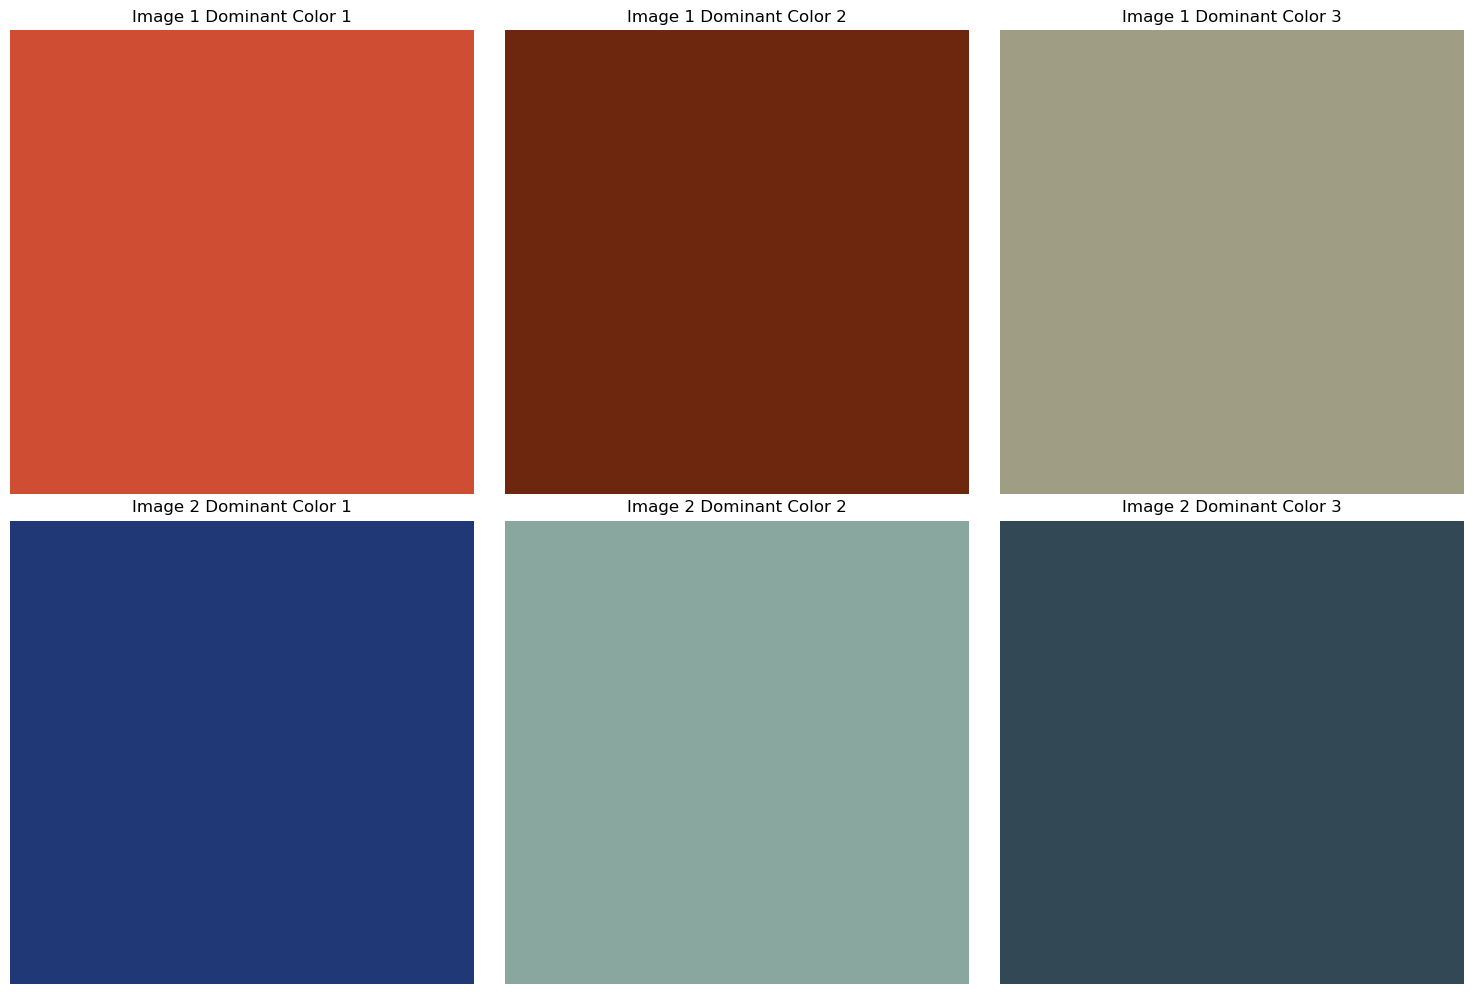

Comparing [  5 192 206] to [112 185 119], Distance: 0.6859439758015226
Comparing [  5 192 206] to [ 83  44 166], Distance: 0.7411064392685166
Comparing [  5 192 206] to [101 104  85], Distance: 0.7929039381492825
Comparing [  8 223 108] to [112 185 119], Distance: 0.5982431167811513
Comparing [  8 223 108] to [ 83  44 166], Distance: 0.8474042732408217
Comparing [  8 223 108] to [101 104  85], Distance: 0.7020381433986479
Comparing [ 29  42 159] to [112 185 119], Distance: 0.7427707749436463
Comparing [ 29  42 159] to [ 83  44 166], Distance: 0.30135539007372975
Comparing [ 29  42 159] to [101 104  85], Distance: 0.5507535643626906
Objects are similar: False


In [73]:
image_path1 = path + 'Segmented_Images/obj_02.jpg'
image_path2 = path + 'Segmented_Images/obj_06.jpg'
compare_and_visualize_colors(image_path1, image_path2)

Top 3 Dominant colors (HSV): [array([  6, 202, 209], dtype=uint8), array([  9, 230, 116], dtype=uint8), array([ 17,  82, 212], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([  5, 192, 206], dtype=uint8), array([  8, 223, 108], dtype=uint8), array([ 29,  42, 159], dtype=uint8)]


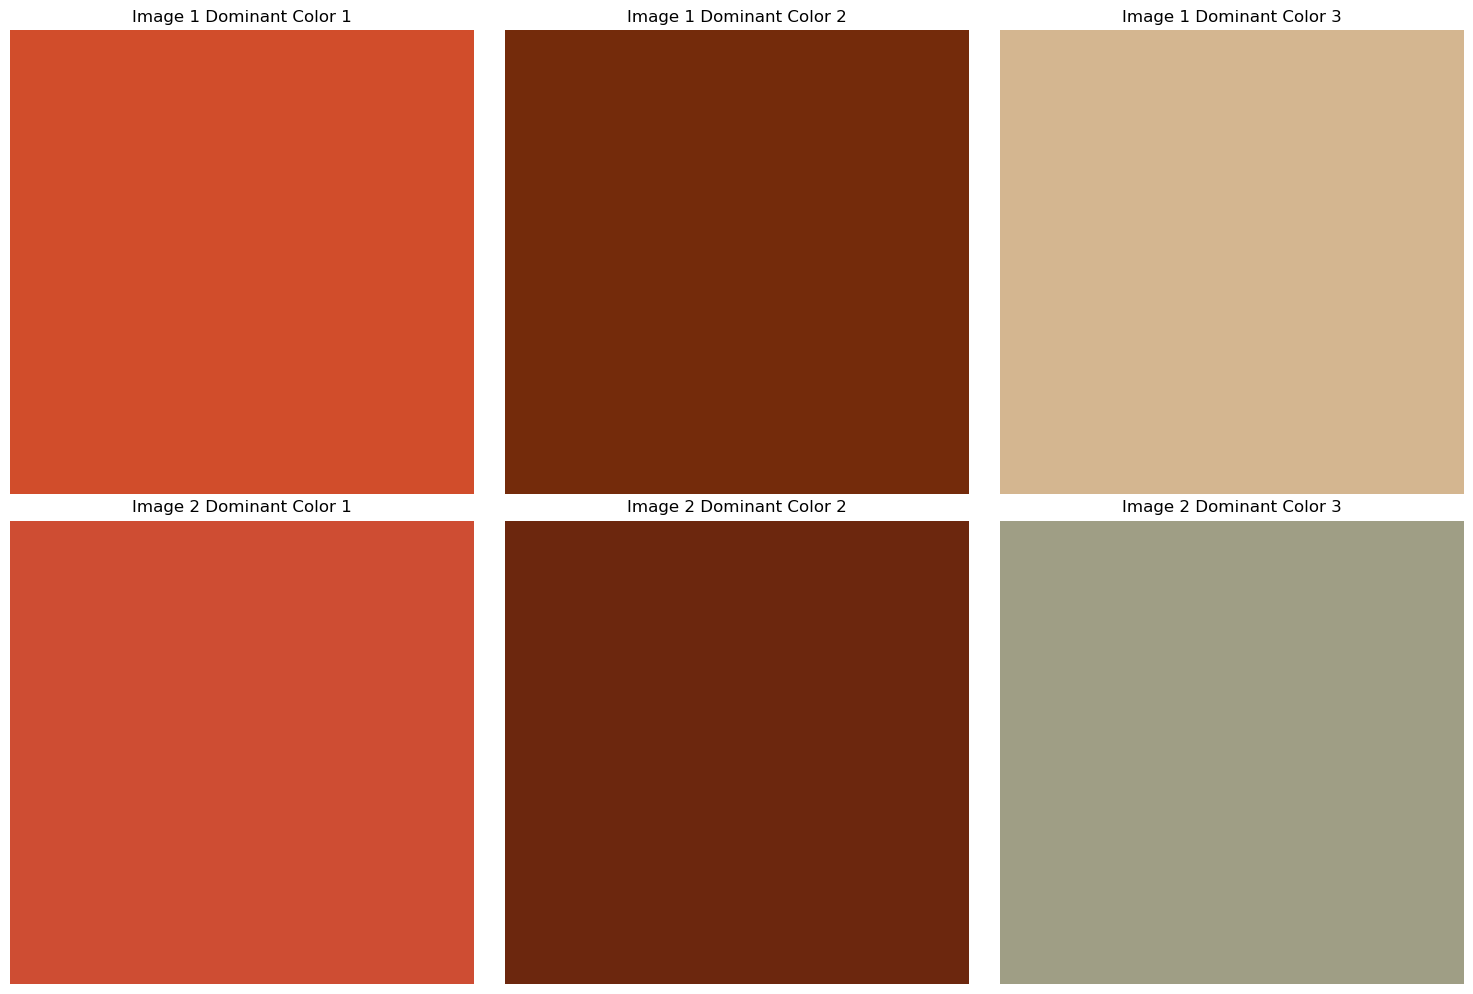

Comparing [  6 202 209] to [  5 192 206], Distance: 0.041317581633124545
Objects are similar: True


In [74]:
image_path1 = path + 'Segmented_Images/obj_01.jpg'
image_path2 = path + 'Segmented_Images/obj_02.jpg'
compare_and_visualize_colors(image_path1, image_path2)

# Find most dominant colors for each object
This part involves processing multiple images of each object to determine the most representative colors. The dominant colors from all images of each object are aggregated to create a reference color profile for each object.

In [75]:
def find_most_dominant_colors(image_path, num_colors=3, ignore_black_threshold=10):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Unable to load the image at path: {image_path}")
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    filtered_image = filter_colors(hsv_image)
    pixel_values = filtered_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    kmeans = KMeans(n_clusters=num_colors + 2, random_state=0, n_init='auto').fit(pixel_values)
    centers = kmeans.cluster_centers_

    # Filter out black colors based on the threshold
    dominant_colors = [color for color in centers if color[2] > ignore_black_threshold]
    
    if len(dominant_colors) > num_colors:
        dominant_colors = sorted(dominant_colors, key=lambda x: -x[2])[:num_colors]
    
    dominant_colors = np.uint8(dominant_colors)
    print("Top 3 Dominant colors (HSV):", dominant_colors)  # Printing the top 3 dominant colors
    return dominant_colors


In [76]:
def process_object_images(directory_path):
    object_colors = {}
    image_files = sorted([f for f in os.listdir(directory_path) if f.startswith('obj_') and f.endswith('.jpg')])

    for i in range(0, len(image_files), 4):
        object_id = f'object_{i//4 + 1}'
        object_colors[object_id] = []

        for j in range(4):
            if i + j < len(image_files):
                image_path = os.path.join(directory_path, image_files[i + j])
                colors = find_most_dominant_colors(image_path, num_colors=3)  # Now returning top 3 colors
                object_colors[object_id].append(colors)  # Storing the top 3 dominant colors for each image

    # Aggregate the top 3 colors for each object
    aggregated_object_colors = {}
    for object_id, color_lists in object_colors.items():
        all_colors = np.vstack(color_lists)
        kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(all_colors)
        aggregated_object_colors[object_id] = kmeans.cluster_centers_.astype(int).tolist()

    return aggregated_object_colors

In [77]:
directory_path = path + 'Segmented_Images'
object_colors_dict = process_object_images(directory_path)

Top 3 Dominant colors (HSV): [[ 15  85 239]
 [  6 202 208]
 [  8 237 121]]
Top 3 Dominant colors (HSV): [[ 18  75 222]
 [  6 201 197]
 [  8 226 105]]
Top 3 Dominant colors (HSV): [[  9 187 233]
 [ 17  55 226]
 [ 28 232 133]]
Top 3 Dominant colors (HSV): [[174  74 237]
 [  1 130 217]
 [  3 164 152]]
Top 3 Dominant colors (HSV): [[  3 162 253]
 [119 132 191]
 [ 25  38 142]]
Top 3 Dominant colors (HSV): [[ 93  87 230]
 [ 84  39 132]
 [111 192 105]]
Top 3 Dominant colors (HSV): [[ 68  70 212]
 [114 182 140]
 [ 90  66 113]]
Top 3 Dominant colors (HSV): [[114  71 202]
 [118 113 151]
 [ 36  83  54]]
Top 3 Dominant colors (HSV): [[ 13  63 243]
 [ 11 205 235]
 [  9 224 157]]
Top 3 Dominant colors (HSV): [[ 26  69 221]
 [ 14 233 186]
 [ 12 167 147]]
Top 3 Dominant colors (HSV): [[ 12  88 230]
 [ 10 215 205]
 [  9 234 146]]
Top 3 Dominant colors (HSV): [[ 10 168 195]
 [  9 206 165]
 [  8 242 144]]
Top 3 Dominant colors (HSV): [[162  77 195]
 [ 14  55 189]
 [  5 233 135]]
Top 3 Dominant colors (HS

In [78]:
print(object_colors_dict)

{'object_1': [[5, 180, 213], [56, 72, 231], [11, 214, 127]], 'object_2': [[69, 97, 224], [58, 56, 110], [115, 154, 146]], 'object_3': [[17, 73, 231], [9, 214, 151], [11, 205, 205]], 'object_4': [[60, 42, 156], [7, 207, 144], [171, 214, 127]], 'object_5': [[19, 57, 214], [79, 233, 113], [90, 163, 180]], 'object_6': [[19, 62, 213], [105, 146, 120], [104, 62, 147]], 'object_7': [[11, 82, 209], [8, 209, 170], [178, 225, 143]], 'object_8': [[17, 56, 189], [138, 59, 103], [16, 39, 83]], 'object_9': [[54, 72, 172], [173, 204, 182], [2, 189, 185]], 'object_10': [[15, 138, 150], [151, 30, 101], [17, 29, 161]]}


In [79]:
def calculate_refined_color_ranges(object_colors):
    refined_color_ranges = {}
    for object_id, color_lists in object_colors.items():
        # Flatten the list of color lists into a single numpy array
        colors_np = np.vstack(color_lists)
        
        # Calculate medians and interquartile ranges
        median = np.median(colors_np, axis=0)
        q1 = np.percentile(colors_np, 25, axis=0)
        q3 = np.percentile(colors_np, 75, axis=0)
        iqr = q3 - q1

        # Calculate acceptable range (median ± 1.5*IQR typically excludes outliers)
        min_color = np.maximum(median - 1.5 * iqr, 0)  # Ensure minimum is not less than 0
        max_color = np.minimum(median + 1.5 * iqr, [180, 255, 255])  # Ensure maximum does not exceed valid HSV values
        
        # Store in dictionary
        refined_color_ranges[object_id] = {
            'H': (int(min_color[0]), int(max_color[0])),
            'S': (int(min_color[1]), int(max_color[1])),
            'V': (int(min_color[2]), int(max_color[2]))
        }
    return refined_color_ranges

In [80]:
def match_dominant_colors(dominant_colors, reference_colors_dict, tolerance=30):
    matches = {}
    for obj, ref_colors_lists in reference_colors_dict.items():
        match_count = 0
        for ref_colors in ref_colors_lists:
            for color in dominant_colors:
                if any(np.allclose(color, ref, atol=tolerance) for ref in ref_colors):
                    match_count += 1
                    break  # Stop checking other ref colors if one matches
        matches[obj] = match_count
    # Sort matches by the number of matches in descending order
    sorted_matches = {k: v for k, v in sorted(matches.items(), key=lambda item: item[1], reverse=True)}
    return sorted_matches

In [81]:
# Example dominant colors dictionary for objects
{'object_1': [[5, 180, 213], [56, 72, 231], [11, 214, 127]], 'object_2': [[69, 97, 224], [58, 56, 110], [115, 154, 146]], 'object_3': [[17, 73, 231], [9, 214, 151], [11, 205, 205]], 'object_4': [[60, 42, 156], [7, 207, 144], [171, 214, 127]], 'object_5': [[19, 57, 214], [79, 233, 113], [90, 163, 180]], 'object_6': [[19, 62, 213], [105, 146, 120], [104, 62, 147]], 'object_7': [[11, 82, 209], [8, 209, 170], [178, 225, 143]], 'object_8': [[17, 56, 189], [138, 59, 103], [16, 39, 83]], 'object_9': [[54, 72, 172], [173, 204, 182], [2, 189, 185]], 'object_10': [[15, 138, 150], [151, 30, 101], [17, 29, 161]]}

# Example dominant colors extracted from an image
dominant_colors_image = [
    np.array([5, 192, 206], dtype=np.uint8),
    np.array([8, 223, 108], dtype=np.uint8),
    np.array([29, 42, 159], dtype=np.uint8)
]

# Matching the dominant colors with the reference object colors
matches = match_dominant_colors(dominant_colors_image, object_colors_dict)
print("Possible matching objects:", matches)

Possible matching objects: {'object_1': 0, 'object_2': 0, 'object_3': 0, 'object_4': 0, 'object_5': 0, 'object_6': 0, 'object_7': 0, 'object_8': 0, 'object_9': 0, 'object_10': 0}


In [82]:
def object_identificator(image_path, reference_colors_dict, output_path=None):
    try:
        # Load and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Unable to load the image at path: {image_path}")

        preprocessed_image = preprocess_image(image)

        # Convert to HSV and segment the object from the background
        hsv_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2HSV)
        lower_green = np.array([31, 13, 40])
        upper_green = np.array([74, 255, 255])
        mask = cv2.inRange(hsv_image, lower_green, upper_green)
        mask = cv2.bitwise_not(mask)
        object_extracted = cv2.bitwise_and(preprocessed_image, preprocessed_image, mask=mask)

        if output_path:
            cv2.imwrite(output_path, object_extracted)

        object_extracted_rgb = cv2.cvtColor(object_extracted, cv2.COLOR_BGR2RGB)
        plt.imshow(object_extracted_rgb)
        plt.axis('off')
        plt.title('Processed and Segmented Image')
        plt.show()

        dominant_colors = find_dominant_colors(image_path, num_colors=3)  # Adjusted function call
        matches = match_dominant_colors(dominant_colors, reference_colors_dict)
        print("Possible matching objects:", matches)

        # Get the top 3 most likely matching objects
        top_3_matches = list(matches.items())[:3]
        print("Top 3 Possible Matching Objects:")
        for obj, count in top_3_matches:
            print(f"{obj}: {count} matches")
            
    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred: {e}")

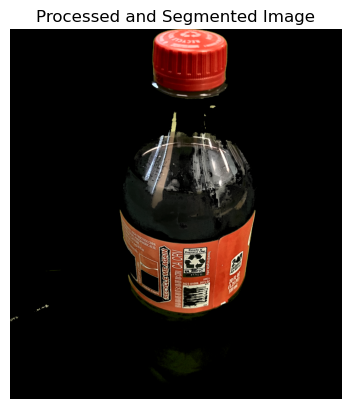

Top 3 Dominant colors (HSV): [array([ 11, 211, 148], dtype=uint8), array([0, 0, 0], dtype=uint8)]
Possible matching objects: {'object_3': 3, 'object_10': 3, 'object_1': 2, 'object_7': 2, 'object_8': 2, 'object_4': 1, 'object_5': 1, 'object_6': 1, 'object_9': 1, 'object_2': 0}
Top 3 Possible Matching Objects:
object_3: 3 matches
object_10: 3 matches
object_1: 2 matches


In [83]:
image_path = path + 'Images/image_02.jpg'
output_path = path + 'Processed_Images/processed_image_02.jpg'
object_identificator(image_path, object_colors_dict, output_path)

# Text Extraction
Here, text is extracted from the images using Tesseract OCR. The extracted text is then matched against known text references for each object to aid in identification.

In [84]:
def extract_text(image_path):
    '''
    Args:
        image_path (str): Path to the input image.
        
    Output:
        text (str): Extracted text from the image.
        
    Usage:
        text = extract_text('image.png')
    '''
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Unable to load the image at path: {image_path}")
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray_image)
    return text.strip()

In [85]:
def create_text_reference(image_folder, num_objects=10, images_per_object=4):
    '''
    Args:
        image_folder (str): Path to the folder containing images.
        num_objects (int): Number of objects to reference.
        images_per_object (int): Number of images per object.
        
    Output:
        text_reference (dict): Dictionary mapping objects to their text references.
        
    Usage:
        text_reference = create_text_reference('images/', 10, 4)
    '''
    text_reference = {}
    
    for obj_num in range(1, num_objects + 1):
        obj_key = f'object_{obj_num}'
        text_reference[obj_key] = []
        
        for img_num in range(1, images_per_object + 1):
            img_index = (obj_num - 1) * images_per_object + img_num
            img_path = os.path.join(image_folder, f'image_{img_index:02d}.jpg')
            extracted_text = extract_text(img_path)
            text_reference[obj_key].append(extracted_text)
    
    # Combine text for each object
    for obj in text_reference:
        text_reference[obj] = ' '.join(text_reference[obj])
    
    return text_reference

# Feature Extraction
This section focuses on extracting ORB (Oriented FAST and Rotated BRIEF) descriptors from the images. These features are matched against precomputed descriptors of reference images to find the closest matches, providing an additional layer of identification accuracy.

In [86]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Unable to load the image at path: {image_path}")
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(gray_image, None)
    return keypoints, descriptors

In [87]:
def map_object_names(object_reference, name_mapping):
    '''
    Args:
        object_reference (dict): Dictionary with object references.
        name_mapping (dict): Dictionary mapping object IDs to names.
        
    Output:
        named_object_reference (dict): Dictionary with named object references.
        
    Usage:
        named_object_reference = map_object_names(object_reference, name_mapping)
    '''
    named_object_reference = {}
    
    for obj_key, value in object_reference.items():
        if obj_key in name_mapping:
            real_name = name_mapping[obj_key]
            named_object_reference[real_name] = value
        else:
            named_object_reference[obj_key] = value  # Keep the original key if no mapping is found
    
    return named_object_reference

In [88]:
def create_feature_reference(image_folder, num_objects=10, images_per_object=4):
    '''
    Args:
        image_folder (str): Path to the folder containing images.
        num_objects (int): Number of objects to reference.
        images_per_object (int): Number of images per object.
        
    Output:
        feature_reference (dict): Dictionary mapping objects to their feature references.
        
    Usage:
        feature_reference = create_feature_reference('images/', 10, 4)
    '''
    feature_reference = {}
    
    for obj_num in range(1, num_objects + 1):
        obj_key = f'object_{obj_num}'
        feature_reference[obj_key] = []
        
        for img_num in range(1, images_per_object + 1):
            img_index = (obj_num - 1) * images_per_object + img_num
            img_path = os.path.join(image_folder, f'image_{img_index:02d}.jpg')
            keypoints, descriptors = extract_features(img_path)
            if descriptors is not None:
                feature_reference[obj_key].append((keypoints, descriptors))
    
    # Combine descriptors for each object
    combined_feature_reference = {}
    for obj in feature_reference:
        if feature_reference[obj]:  # Ensure the list is not empty
            descriptors_list = [descriptors for _, descriptors in feature_reference[obj]]
            combined_descriptors = np.vstack(descriptors_list)
            combined_feature_reference[obj] = combined_descriptors
        else:
            combined_feature_reference[obj] = np.empty((0, 32))  # Assuming ORB descriptor size is 32
    
    return combined_feature_reference

image_folder = path + "Images"

feature_reference = create_feature_reference(image_folder)
feature_reference_named = map_object_names(feature_reference, name_mapping)

# Ensure the feature_reference_named is correctly created
print("Feature Reference Named:")
for obj, descriptors in feature_reference_named.items():
    print(f"{obj}: {descriptors.shape} descriptors")

Feature Reference Named:
Coca Cola: (2000, 32) descriptors
Pepsi: (2000, 32) descriptors
Orange Crush: (2000, 32) descriptors
Cup Noodles: (2000, 32) descriptors
Lays Salt & Vinegar: (2000, 32) descriptors
Oreo mini: (2000, 32) descriptors
Cheeze_it: (2000, 32) descriptors
Deep River Chips: (2000, 32) descriptors
Ritz Cracker: (2000, 32) descriptors
Milano Cookie: (2000, 32) descriptors


# Combination
In this final section, the results from dominant color extraction, text extraction, and feature extraction are combined to make a final decision on the object identification. Feature extraction is given more weight in the final decision to enhance accuracy. The top three most likely matching objects are identified based on the combined scores.

In [89]:
def preprocess_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    processed_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return processed_img

In [90]:
# Define the paths and mappings
image_folder = '/Users/RayChen/csci0452/Final_Project/Images'
# Create text and feature references
text_reference = create_text_reference(image_folder)
text_reference_named = map_object_names(text_reference, name_mapping)

# Ensure the text_reference_named is correctly created
print("Text Reference Named:")
for obj, text in text_reference_named.items():
    print(f"{obj}: {text}")

Text Reference Named:
Coca Cola:   Protein by
5 Not
Calories 240 fat

per serving vit D ‘
C02 THE COCO Ca

‘Pm a 100%

(| ‘innit Or
isto
calcium, fo

so 
Pepsi:    
Orange Crush:  joytd UNDER THEA
i 175084, ™ & CR-0109 ORHC.00323Z

TUFORPEPPER/SEVEN U

CAFRPERISEVEN UP, ING, 
Cup Noodles: Me

N05 //000-— 4 7
Mad . ie it AS SN

NOMSIIINS ININUTS
RE,

ED ey PRRRRRRRERR EE

\

Lt Silt BITE: BOE IESE Ss SH AERA ANID 8), ( SSepeegeceell 8 ee
%S\-

%0

%0

a .
<>
93975, \8?

*SuOI}IOIIP Hulyood papuewwi0dss.

10} pl| 88S aseajd ‘S}jNSel }Sal}Se} 9Y} 104

; _ SLONGOYd HSI4 CNV
HSI4TISHS NVIOVLSNYO ‘SLOAN 34¥l “LANV4d
S3SSII0Nd OSTV LVHL ALITIOVS V NI G3YNLOVANNVIN

“SINSIGIYONI C004 G3YIINIONAOIS SNIVLNOD

67206 V9 ‘YNACHVD “AV SNVHOSSOY M 1002 ©
‘NI “09 (VSN) SGOO4 NISSIN +A8 G3YNLOVINNYW

<INIUHS CNY ‘JINVS3S ‘TIN ‘993 ‘NV3GA0S ‘VJHM SNIVINOD

‘GNIWAUASSHd)
DHL “UVONS ‘GIOV DINIDONS "2014S “LIS “SNV38A0S
‘IW3HM) SOMOS JONVS A0S ‘AIVHdSOHdATOdIeL WNIOS
JIVNOGHVD WNIGOS ‘JIVNIDTY WNIGOS "YadM

In [91]:
def combined_pipeline(image_path, reference_colors_dict, text_reference=None, feature_reference=None, name_mapping=None, feature_weight=5):
    '''
    Args:
        image_path (str): Path to the input image.
        reference_colors_dict (dict): Dictionary of reference colors.
        text_reference (dict, optional): Dictionary of text references. Default is None.
        feature_reference (dict, optional): Dictionary of feature references. Default is None.
        name_mapping (dict, optional): Dictionary mapping object IDs to names. Default is None.
        feature_weight (int, optional): Weight for feature matching. Default is 5.
        
    Output:
        result (dict): Dictionary containing the combined results.
        
    Usage:
        result = combined_pipeline('image.png', reference_colors, text_ref, feature_ref, name_map, 5)
    '''
    try:
        # Step 1: Preprocessing and Segmentation
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Unable to load the image at path: {image_path}")

        preprocessed_image = preprocess_image(image)
        hsv_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2HSV)
        lower_green = np.array([31, 13, 40])
        upper_green = np.array([74, 255, 255])
        mask = cv2.inRange(hsv_image, lower_green, upper_green)
        mask = cv2.bitwise_not(mask)
        object_extracted = cv2.bitwise_and(preprocessed_image, preprocessed_image, mask=mask)

        object_extracted_rgb = cv2.cvtColor(object_extracted, cv2.COLOR_BGR2RGB)
        plt.imshow(object_extracted_rgb)
        plt.axis('off')
        plt.title('Processed and Segmented Image')
        plt.show()

        # Step 2: Dominant Color Extraction
        dominant_colors = find_dominant_colors(image_path, num_colors=3)
        color_matches = match_dominant_colors(dominant_colors, reference_colors_dict)
        print("Possible matching objects (color):", color_matches)

        # Step 3: Text Extraction
        extracted_text = extract_text(image_path)
        print("Extracted Text:", extracted_text)
        text_matches = {}
        if text_reference:
            for obj, ref_text in text_reference.items():
                if ref_text.lower() in extracted_text.lower():
                    text_matches[obj] = 1
        print("Possible matching objects (text):", text_matches)

        # Step 4: Feature Extraction
        keypoints, descriptors = extract_features(image_path)
        feature_matches = {}
        if feature_reference:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            for obj, ref_descriptors in feature_reference.items():
                matches = bf.match(descriptors, ref_descriptors)
                matches = sorted(matches, key=lambda x: x.distance)
                feature_matches[obj] = len(matches)
        print("Possible matching objects (features):", feature_matches)

        # Step 5: Combine Decisions with Weighting (we added weight to feature extraction because it works the best)
        combined_matches = {}
        for obj in reference_colors_dict.keys():
            real_name = name_mapping.get(obj, obj)
            combined_matches[real_name] = color_matches.get(obj, 0) + text_matches.get(real_name, 0) + feature_weight * feature_matches.get(real_name, 0)
        
        # Get the top 3 most likely matching objects
        top_3_matches = sorted(combined_matches.items(), key=lambda item: item[1], reverse=True)[:3]
        print("Top 3 Possible Matching Objects:")
        for obj, count in top_3_matches:
            print(f"{obj}: {count} matches")

        return top_3_matches

    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred: {e}")

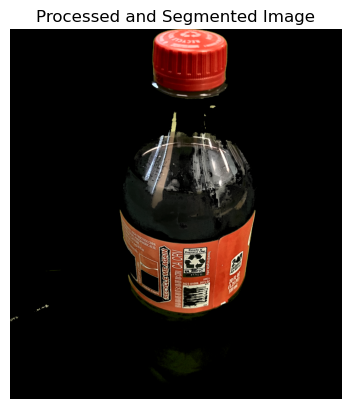

Top 3 Dominant colors (HSV): [array([ 11, 211, 148], dtype=uint8), array([0, 0, 0], dtype=uint8)]
Possible matching objects (color): {'object_3': 3, 'object_10': 3, 'object_1': 2, 'object_7': 2, 'object_8': 2, 'object_4': 1, 'object_5': 1, 'object_6': 1, 'object_9': 1, 'object_2': 0}
Extracted Text: 
Possible matching objects (text): {}
Possible matching objects (features): {'Coca Cola': 500, 'Pepsi': 226, 'Orange Crush': 274, 'Cup Noodles': 244, 'Lays Salt & Vinegar': 250, 'Oreo mini': 271, 'Cheeze_it': 239, 'Deep River Chips': 269, 'Ritz Cracker': 275, 'Milano Cookie': 239}
Top 3 Possible Matching Objects:
Coca Cola: 2502 matches
Ritz Cracker: 1376 matches
Orange Crush: 1373 matches


[('Coca Cola', 2502), ('Ritz Cracker', 1376), ('Orange Crush', 1373)]

In [92]:
# Example usage
image_path = '/Users/RayChen/csci0452/Final_Project/Images/image_02.jpg'
output_path = '/Users/RayChen/csci0452/Final_Project/Segmented_Images/obj_02.jpg'

combined_pipeline(image_path, object_colors_dict, text_reference_named, feature_reference_named, name_mapping)

In [93]:
object_colors_dict = {
    'object_1': [[15, 85, 239], [6, 202, 208], [8, 237, 121]],
    'object_2': [[3, 162, 253], [119, 132, 191], [25, 38, 142]],
    'object_3': [[13, 63, 243], [11, 205, 235], [9, 224, 157]],
    'object_4': [[162, 77, 195], [14, 55, 189], [5, 233, 135]],
    'object_5': [[21, 92, 221], [106, 157, 167], [8, 218, 134]],
    'object_6': [[15, 72, 229], [100, 57, 152], [103, 138, 107]],
    'object_7': [[15, 82, 229], [12, 176, 224], [15, 216, 156]],
    'object_8': [[20, 48, 221], [17, 151, 188], [131, 60, 103]],
    'object_9': [[4, 146, 209], [169, 200, 172], [2, 226, 139]],
    'object_10': [[17, 28, 181], [13, 33, 115], [171, 35, 100]]
}

### UI:
In our project, we designed a user-friendly graphical user interface (UI) to facilitate image processing and analysis using various computer vision techniques. The UI was built using the Tkinter library in Python, which provides a robust framework for developing desktop applications. Below, we describe the key methods and components involved in creating the UI interface.

1. Loading and Processing Database Images
We created a function, load_database_images(), to load and process a set of pre-segmented images stored in the project directory. Each image was processed to extract key features, text, and dominant colors, which were then stored in a dictionary for later use in comparisons.

2. Extracting ORB Descriptors
ORB (Oriented FAST and Rotated BRIEF) descriptors were extracted using the extract_orb_descriptors() function. This function reads an image, converts it to grayscale, and computes keypoints and descriptors using the ORB algorithm.

3. Displaying Results
The UI displays the results of image processing in three sections: Dominant Color, Text Extraction, and Feature Matching. Each section is handled by specific functions and UI components.

In [94]:
def extract_orb_descriptors_from_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(gray_image, None)
    return keypoints, descriptors

In [95]:
def load_image():
    global img_path, loaded_image, display_img
    img_path = filedialog.askopenfilename()
    if img_path:
        loaded_image = cv2.imread(img_path)
        image = Image.open(img_path)
        image.thumbnail((300, 300), Image.LANCZOS)
        display_img = ImageTk.PhotoImage(image)
        img_label.config(image=display_img)
        img_label.image = display_img

In [96]:
def show_hsv_color_on_canvas(canvas, hsv_values):
    '''
    Args:
        canvas (ndarray): The canvas to show the HSV color.
        hsv_values (list or ndarray): List or array of HSV values.
        
    Output:
        None
        
    Usage:
        show_hsv_color_on_canvas(canvas, [30, 255, 255])
    '''
    if isinstance(hsv_values, list):
        hsv_values = np.array(hsv_values)
    
    if hsv_values.ndim == 1:
        hsv_values = hsv_values[np.newaxis, np.newaxis, :]
    elif hsv_values.ndim == 2 and hsv_values.shape[0] == 1:
        hsv_values = hsv_values[np.newaxis, :]

    color_image = np.uint8(hsv_values)
    color_image = cv2.cvtColor(color_image, cv2.COLOR_HSV2BGR)
    color_image = np.tile(color_image, (200, 200, 1))
    rgb_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(rgb_image)
    img_tk = ImageTk.PhotoImage(img_pil)
    canvas.create_image(0, 0, anchor='nw', image=img_tk)
    canvas.image = img_tk

In [97]:
def load_database_images():
    '''
    Args:
        None
        
    Output:
        database_images (dict): Dictionary containing the loaded database images and their features.
        
    Usage:
        database_images = load_database_images()
    '''
    database_images = {}
    for i in range(1, 41):
        img_path = os.path.join(path, f'Segmented_Images/obj_{i:02d}.jpg')
        if os.path.exists(img_path):
            keypoints, descriptors = extract_features(img_path)
            text = extract_text(img_path)
            color = find_dominant_colors(img_path)
            database_images[i] = {
                'path': img_path,
                'keypoints': keypoints,
                'descriptors': descriptors,
                'text': text,
                'color': color
            }
    return database_images

database_images = load_database_images()

Top 3 Dominant colors (HSV): [array([  6, 202, 209], dtype=uint8), array([  9, 230, 116], dtype=uint8), array([ 17,  82, 212], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([  5, 192, 206], dtype=uint8), array([  8, 223, 108], dtype=uint8), array([ 29,  42, 159], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([ 11, 155, 238], dtype=uint8), array([28, 39, 92], dtype=uint8), array([0, 0, 0], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([173,  74, 237], dtype=uint8), array([  2, 144, 192], dtype=uint8), array([0, 0, 0], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([  3, 162, 253], dtype=uint8), array([115, 163, 147], dtype=uint8), array([ 27,  38, 143], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([112, 185, 119], dtype=uint8), array([ 83,  44, 166], dtype=uint8), array([101, 104,  85], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([114, 180, 139], dtype=uint8), array([0, 0, 0], dtype=uint8)]
Top 3 Dominant colors (HSV): [array([114,  72, 201], dtype=uint8), arra

In [98]:
def map_image_index_to_object(image_index):
    # There are 4 images per object, map image index to object number
    object_index = (image_index - 1) // 4 + 1
    return f'object_{object_index}'

In [99]:
def process_and_compare_image():
    '''
    Args:
        None
        
    Output:
        None
        
    Usage:
        UI Of Final Results.
    '''
    if not img_path:
        messagebox.showerror("Error", "No image loaded")
        return

    processed_image = preprocess_image(loaded_image)  # Pass the actual image data
    kp1, des1 = extract_orb_descriptors_from_image(processed_image)
    text1 = extract_text(img_path)
    color1 = find_dominant_colors(img_path)

    best_match_color = None
    best_match_text = None
    best_match_features = None
    min_color_diff = float('inf')
    max_text_similarity = 0  # Placeholder for text similarity calculation
    max_features_match = 0

    # Store the top 3 color matches
    color_match_scores = []

    for idx, data in database_images.items():
        object_id = (idx - 1) // 4 + 1
        color1_array = np.array(color1[0])  # Convert the first dominant color to a numpy array
        data_color_array = np.array(data['color'])  # Convert the reference color to a numpy array

        # Calculate color difference
        color_diff = np.linalg.norm(color1_array - data_color_array)
        color_match_scores.append((color_diff, object_id))

        if color_diff < min_color_diff:
            min_color_diff = color_diff
            best_match_color = idx

        # Dummy similarity calculation for text
        text_similarity = 1  # Placeholder, implement actual similarity calculation
        if text_similarity > max_text_similarity:
            max_text_similarity = text_similarity
            best_match_text = idx

        # Feature matching
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1, data['descriptors'])
        if len(matches) > max_features_match:
            max_features_match = len(matches)
            best_match_features = idx

    # Sort the color match scores to find the top 3
    top3_color_matches = sorted(color_match_scores, key=lambda x: x[0])[:3]

    # Map the top 3 color matches to object names
    top3_color_match_text = "\n".join([f"{name_mapping[f'object_{idx}']}" for _, idx in top3_color_matches])
    best_color_match_label.config(text=f"Top 3 Color Matches:\n{top3_color_match_text}")

    # Display the best text match image
    try:
        best_text_match_img = Image.open(database_images[best_match_text]['path'])
        best_text_match_img.thumbnail((200, 200), Image.LANCZOS)
        best_text_match_photo = ImageTk.PhotoImage(best_text_match_img)
        best_text_match_label.config(image=best_text_match_photo)
        best_text_match_label.image = best_text_match_photo
    except Exception as e:
        print(f"Error loading best text match image: {e}")

    # Display the best feature match image
    try:
        best_feature_match_img = Image.open(database_images[best_match_features]['path'])
        best_feature_match_img.thumbnail((200, 200), Image.LANCZOS)
        best_feature_match_photo = ImageTk.PhotoImage(best_feature_match_img)
        best_feature_match_label.config(image=best_feature_match_photo)
        best_feature_match_label.image = best_feature_match_photo
    except Exception as e:
        print(f"Error loading best feature match image: {e}")

    # Show the dominant color on the canvas
    try:
        show_hsv_color_on_canvas(color_canvas, color1[0])
        hsv_value_label.config(text=f"HSV: {color1[0]}")
    except Exception as e:
        print(f"Error displaying dominant color: {e}")

    # Display the extracted text
    try:
        text_extraction_result.delete('1.0', tk.END)
        text_extraction_result.insert(tk.END, text1)
    except Exception as e:
        print(f"Error displaying text extraction result: {e}")

    # Display feature matching result
    try:
        img1 = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(database_images[best_match_features]['path']), cv2.COLOR_BGR2RGB)
        feature_match_result = cv2.drawMatches(img1, kp1, img2, database_images[best_match_features]['keypoints'], matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        feature_match_img = Image.fromarray(feature_match_result)
        feature_match_img.thumbnail((200, 200), Image.LANCZOS)
        feature_match_photo = ImageTk.PhotoImage(feature_match_img)
        best_feature_match_label.config(image=feature_match_photo)
        best_feature_match_label.image = feature_match_photo
    except Exception as e:
        print(f"Error displaying feature matching result: {e}")

    # Use the combined_pipeline function to get the final identification
    try:
        final_identification = combined_pipeline(img_path, object_colors_dict, text_reference_named, feature_reference_named, name_mapping)
        combined_matches_text = "\n".join([f"{name}: {count} matches" for name, count in final_identification])
        combined_top3_label.config(text=f"Top 3 Combined Matches:\n{combined_matches_text}")
        final_identification_label.config(text=f"Identified Object: {final_identification[0][0]}")
    except Exception as e:
        print(f"Error with combined_pipeline: {e}")

Top 3 Dominant colors (HSV): [array([  5, 221, 167], dtype=uint8), array([1, 0, 1], dtype=uint8)]


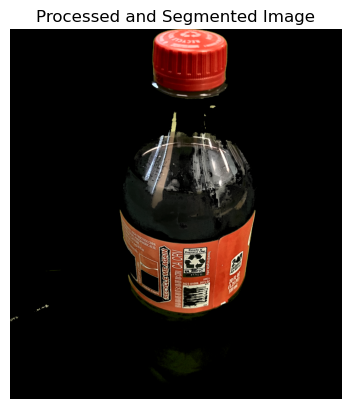

Top 3 Dominant colors (HSV): [array([ 11, 211, 148], dtype=uint8), array([0, 0, 0], dtype=uint8)]
Possible matching objects (color): {'object_1': 3, 'object_3': 3, 'object_7': 3, 'object_2': 2, 'object_4': 2, 'object_5': 2, 'object_8': 2, 'object_9': 2, 'object_10': 2, 'object_6': 1}
Extracted Text: 
Possible matching objects (text): {}
Possible matching objects (features): {'Coca Cola': 500, 'Pepsi': 226, 'Orange Crush': 274, 'Cup Noodles': 244, 'Lays Salt & Vinegar': 250, 'Oreo mini': 271, 'Cheeze_it': 239, 'Deep River Chips': 269, 'Ritz Cracker': 275, 'Milano Cookie': 239}
Top 3 Possible Matching Objects:
Coca Cola: 2503 matches
Ritz Cracker: 1377 matches
Orange Crush: 1373 matches


In [101]:
window = tk.Tk()
window.title("MiddXpress Image Checkout")

img_label = Label(window)
img_label.grid(row=0, column=1, pady=20)

load_button = Button(window, text="Load Image", command=load_image)
load_button.grid(row=1, column=0, padx=20)

process_button = Button(window, text="Process Image", command=process_and_compare_image)
process_button.grid(row=1, column=2, padx=20)

color_canvas = Canvas(window, width=200, height=200)
color_canvas.grid(row=2, column=0)

hsv_value_label = Label(window, text="HSV: N/A")
hsv_value_label.grid(row=3, column=0)

text_extraction_result = Text(window, height=10, width=30)
text_extraction_result.grid(row=2, column=1, rowspan=2)

best_color_match_label = Label(window, text="Top 3 Color Matches: N/A")
best_color_match_label.grid(row=4, column=0)

best_text_match_label = Label(window)
best_text_match_label.grid(row=4, column=1)

best_feature_match_label = Label(window)
best_feature_match_label.grid(row=2, column=2)

color_label = Label(window, text="Dominant Color Result")
color_label.grid(row=5, column=0)
text_label = Label(window, text="Text Extraction Result")
text_label.grid(row=5, column=1)
feature_label = Label(window, text="Feature Matching Result")
feature_label.grid(row=3, column=2)

final_identification_label = Label(window, text="Identified Object: N/A")
final_identification_label.grid(row=6, column=1)

combined_top3_label = Label(window, text="Top 3 Combined Matches: N/A")
combined_top3_label.grid(row=4, column=2)

window.mainloop()

### Result Demonstration

Here we demonstrate some results we got along the testing process together with screenshots of the final product with the user interface where we combine the three methods into a complete pipeline. The code and demo is also included in the later code sections. The UI code is placed at the end of the code part.


**1. Results For Dominant Color**

**DC1**

*Comments*: This screenshot demonstrates the extraction of the top 3 dominant colors from two images. The HSV values for each color are displayed above each color box. The extracted dominant colors are visually distinct and accurately represent the most prominent colors in the images. The comparison at the bottom shows the distance between the colors, indicating how similar or different the colors are between the two images.

**DC2**

*Comments*: This screenshot compares the dominant colors between a Coca-Cola and a Pepsi can. The extracted colors clearly represent the primary branding colors of each product. The comparison shows a significant distance, indicating that the colors are distinctly different, which aligns with our expectations.

**2. Results For Text Extraction**

**TE1**

*Comments*: This screenshot shows the extracted text from a product label. The OCR process has accurately captured most of the text, although there are some errors such as "OSTINCTIVE" instead of "DISTINCTIVE" and "NETWT602(t 70q)" instead of "NET WT 6 OZ (170g)". These errors suggest that further refinement of the OCR parameters or preprocessing steps may be necessary for improved accuracy.

**3. Results For Feature Extraction**

**FE1**

*Comments*: This screenshot demonstrates feature matching using the ORB (Oriented FAST and Rotated BRIEF) algorithm. The lines connecting the two images indicate matched features. The high number of matches (132) suggests a strong similarity between the two images, which is expected as both images are of the same product (Cheez-It).

**4. Results For Our Combined UI Final Pipeline**

**UI1**

*Comments*: This screenshot shows the final UI interface after processing an image of a Coca Cola bottle. Although the UI doesn't correctly displays the dominant color, it correctly displayed the extracted text, and feature matching result. And the dominant color matches the primary color of the package is fairly accurate, and the conclusive matching shows a correct match with the stored database image.

**UI2**

*Comments*: This image shows the final UI interface after processing an image of a Milano Cookie Package. We can see that although the UI does not displays the extracted text and predicted picture, it has correct dominant color, feature matching result, and a good final prediction. The dominant color matches the primary color of the package, the text extraction has some errors, and the feature matching shows a correct match with the stored database image. The errors in text extraction suggest that the OCR process may need further refinement for this specific product.

### Accessibility
Our project on using image processing techniques for grocery checkout significantly improves accessibility and efficiency in various ways. 

By enabling automated checkout, it helps individuals with disabilities by minimizing the need for physical interaction with checkout staff and reducing the complexities associated with traditional checkout processes. This system can expedite the shopping experience, making it easier for people with mobility issues to navigate through the store and complete their purchases independently. Additionally, automated checkout systems can incorporate features like audio guidance for visually impaired users, enhancing their shopping experience.

Furthermore, the use of digital systems reduces the need for physical price tags, contributing to environmental sustainability by decreasing paper waste. This approach aligns with modern trends in grocery store automation, which aim to improve efficiency and customer satisfaction while also supporting eco-friendly practices

### Ethical Concerns

1. Unemployment: The implementation of automated checkout systems could lead to job displacement for cashiers and other retail workers. As automation increases, the demand for human labor in these roles may decrease, contributing to higher unemployment rates and economic instability for affected workers.

2. Privacy Concerns: The use of cameras and image processing raises significant privacy issues. These systems could inadvertently capture personal information or images of individuals other than the groceries being checked out. Ensuring robust privacy measures and transparency about data usage is crucial to address these concerns.

3. Security Risks: Automated systems could be vulnerable to hacking and other security breaches. Criminals might exploit these systems to commit fraud or theft. Ensuring the security of the system and protecting it against such vulnerabilities is essential to prevent misuse.

### Schedule vs Reality

Initially, our project followed the planned schedule closely, particularly in the early stages where we researched and implemented individual components. However, we encountered significant delays during the database construction phase. Unresolved background noise in images necessitated retaking the entire dataset with a self-made green screen, which set us back by almost a week. Additionally, integrating feature extraction and matching took longer than anticipated due to unforeseen bugs.

We have also changed our schedule for the last 2 weeks as we shifted our focus from successfully implementing multiple object detection to creating a clear and functional user interface for better visualizations while exploring the multiple object detection within single image. 

Despite these setbacks, we successfully developed a functional UI and thoroughly tested all components, albeit with a slight extension to our original timeline. This experience highlighted the importance of flexibility in project planning and the need for contingency measures when dealing with complex, real-world datasets.

### Issues?

During the development of our project, we encountered several issues that impacted both our methods and schedule. Here’s a detailed account of the primary challenges and how we addressed them:

1. Color-Based Object Identification: Initially, we attempted to distinguish between similar items like parsley and cilantro using color features. However, this proved unreliable due to the subtle color differences. Additionally, selecting the correct number of colors ('num_colors') for the K-means clustering algorithm was challenging, leading to inconsistent results. To mitigate this, we incorporated Method #3, which leverages DBSCAN clustering to provide a more robust object identification process.

2. Text Detection Difficulties: Our initial attempts at text detection using Pytesseract were met with mixed success, particularly with text-dominant items. The text extraction often missed or incorrectly identified characters, reducing the reliability of this method. We refined our approach by optimizing the image preprocessing steps and enhancing the text extraction algorithm, which improved accuracy.

3. Feature Extraction Setbacks: In the beginning, we utilized SIFT (Scale-Invariant Feature Transform) for feature extraction. However, SIFT did not perform well with our grocery items due to variations in image scale and perspective. We transitioned to using mainly ORB (Oriented FAST and Rotated BRIEF) features, which provided better performance and more consistent results.

4. Database Image Challenges: Constructing our image database took longer than anticipated due to unresolved background noise in the images. This noise hindered our object detection accuracy. To address this, we retook all images using a self-made green screen to ensure a uniform background. This step significantly improved our segmentation and recognition processes 
but delayed our progress.

5. Finally, We have a UI issue that the text identification method is not very useful when there isn't much text in the image, it always gives the same image prediction in the UI. We will try to fix this.


### Future Work

1. Enlarge Dataset: Expand the dataset to include a wider variety of grocery items for better system training. Our dataset is fairly small and larger dataset could better serve its true purpose and be applied in the real life settings. But that might be achieved with additional methods like Deep Learning models.

2. Improved Clustering Algorithm: Research and implement more effective clustering algorithms to improve color detection accuracy.

3. Top 3 Dominant Colors: Enhance the color detection method to identify the top three dominant colors instead of just one.

4. Multiple Item Detection: Experiment with color segmentation techniques for detecting multiple items within a single image.

5. Price Calculation: Add functionalities for gross price calculation, allowing users to obtain price estimates directly from the images.

6. Although we have created the UI for better accessibility and visualization purposes, we can still improve the running time and efficiency of it as it is running a little longer than we hoped for, which will also undermine the efficiency of the checkout process.


### Refrence

1. Picoult, J. (2024, May 9). A self-checkout that customers love? this company created it. Forbes. https://www.forbes.com/sites/jonpicoult/2023/12/21/a-self-checkout-that-customers-love--this-company-created-it/?sh=6b849a58667a 

2. Tyagi, D. (2020, April 7). Introduction to orb (oriented fast and rotated brief). Medium. https://medium.com/@deepanshut041/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf 

3. Tyagi, D. (2020a, April 7). Introduction to harris corner detector. Medium. https://medium.com/@deepanshut041/introduction-to-harris-corner-detector-32a88850b3f6 

4. Simplifying grocery checkout with Deep Learning. (n.d.). http://cs230.stanford.edu/projects_fall_2019/reports/26257432.pdf 

5. Python tkinter. GeeksforGeeks. (2024, May 9). https://www.geeksforgeeks.org/python-gui-tkinter/